## Routing in LangGraph

**Routing** allows you to direct the flow of execution to different nodes based on conditions. It's like a traffic controller that decides which path to take.

### Why Use Routing?
- **Specialization**: Route to different experts/models for different tasks
- **Efficiency**: Skip unnecessary processing
- **Flexibility**: Handle diverse input types in one graph

### Example Scenario
A customer support system that routes questions to:
- **Math Expert** - for calculation questions
- **Code Expert** - for programming questions  
- **General Expert** - for other questions

```
                    ┌─────────────┐
                    │   classify  │
                    └──────┬──────┘
                           │
         ┌─────────────────┼─────────────────┐
         ▼                 ▼                 ▼
   ┌───────────┐    ┌───────────┐    ┌───────────┐
   │math_expert│    │code_expert│    │general_exp│
   └─────┬─────┘    └─────┬─────┘    └─────┬─────┘
         │                │                │
         └────────────────┼────────────────┘
                          ▼
                    ┌─────────────┐
                    │     END     │
                    └─────────────┘
```

In [7]:
import os
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

load_dotenv()
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL")

# Initialize the LLM
llm = ChatOllama(model="minimax-m2.5:cloud", base_url=OLLAMA_BASE_URL)

In [8]:
from typing import Literal

# Define the State
class State(TypedDict):
    question: str          # Input: the user's question
    category: str          # Classification result
    answer: str            # Final answer

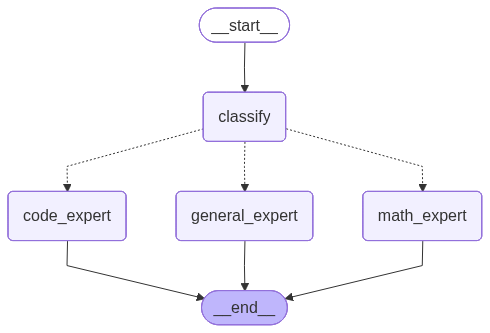

In [9]:
# Define the nodes
def classify_question(state: State) -> State:
    """Classify the question into a category."""
    question = state["question"]
    
    # Use LLM to classify the question
    prompt = f"""Classify this question into one of these categories:
    - "math" - for calculation or math questions
    - "code" - for programming or code questions
    - "general" - for everything else
    
    Question: {question}
    
    Return only the category name."""
    
    response = llm.invoke(prompt)
    category = response.content.strip().lower()
    
    # Ensure valid category
    if category not in ["math", "code", "general"]:
        category = "general"
    
    return {"category": category}


def math_expert(state: State) -> State:
    """Answer math questions."""
    question = state["question"]
    prompt = f"You are a math expert. Answer this math question:\n\n{question}"
    response = llm.invoke(prompt)
    return {"answer": response.content}


def code_expert(state: State) -> State:
    """Answer code questions."""
    question = state["question"]
    prompt = f"You are a coding expert. Help with this programming question:\n\n{question}"
    response = llm.invoke(prompt)
    return {"answer": response.content}


def general_expert(state: State) -> State:
    """Answer general questions."""
    question = state["question"]
    prompt = f"You are a general assistant. Answer this question:\n\n{question}"
    response = llm.invoke(prompt)
    return {"answer": response.content}


# Build the graph
builder = StateGraph(State)

# Add nodes
builder.add_node("classify", classify_question)
builder.add_node("math_expert", math_expert)
builder.add_node("code_expert", code_expert)
builder.add_node("general_expert", general_expert)

# Add START edge
builder.add_edge(START, "classify")

# Add conditional edges from classify to route to appropriate expert
def route_question(state: State) -> Literal["math_expert", "code_expert", "general_expert"]:
    """Route to the appropriate expert based on category."""
    category = state["category"]
    # Map category to expert node name
    return f"{category}_expert"

builder.add_conditional_edges(
    "classify",
    route_question,
    {
        "math_expert": "math_expert",
        "code_expert": "code_expert",
        "general_expert": "general_expert"
    }
)

# Add edges from experts to END
builder.add_edge("math_expert", END)
builder.add_edge("code_expert", END)
builder.add_edge("general_expert", END)

# Compile the graph
graph = builder.compile()

# Display the graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph structure created successfully!")
    print("\nNodes: classify, math_expert, code_expert, general_expert")
    print("Edges: START -> classify -> [conditional: math_expert|code_expert|general_expert] -> END")

In [10]:
# Test the routing graph
print("Testing the routing graph with different question types:\n")

# Test 1: Math question
print("=" * 60)
print("Test 1: Math Question")
print("=" * 60)
result = graph.invoke({"question": "What is 15 times 27?"})
print(f"Question: {result['question']}")
print(f"Category: {result['category']}")
print(f"Answer: {result['answer']}")

# Test 2: Code question
print("\n" + "=" * 60)
print("Test 2: Code Question")
print("=" * 60)
result = graph.invoke({"question": "How do I reverse a list in Python?"})
print(f"Question: {result['question']}")
print(f"Category: {result['category']}")
print(f"Answer: {result['answer']}")

# Test 3: General question
print("\n" + "=" * 60)
print("Test 3: General Question")
print("=" * 60)
result = graph.invoke({"question": "What is the capital of France?"})
print(f"Question: {result['question']}")
print(f"Category: {result['category']}")
print(f"Answer: {result['answer']}")

Testing the routing graph with different question types:

Test 1: Math Question
Question: What is 15 times 27?
Category: math
Answer: 15 × 27 = 405.

Test 2: Code Question
Question: How do I reverse a list in Python?
Category: code
Answer: Here are the most common ways to reverse a list in Python, together with when you’d want to use each one.

---

## 1. **In‑place reversal with `list.reverse()`**

```python
my_list = [1, 2, 3, 4, 5]
my_list.reverse()        # modifies the original list
print(my_list)           # → [5, 4, 3, 2, 1]
```

* **What it does:** Reverses the list **in place** – no new list is created.
* **Return value:** `None` (the list itself is mutated).
* **Use‑case:** When you don’t need the original order and want to save memory.

---

## 2. **Get a reversed iterator with `reversed()`**

```python
my_list = [1, 2, 3, 4, 5]
rev_iter = reversed(my_list)   # returns an iterator
print(list(rev_iter))          # → [5, 4, 3, 2, 1]
```

* **What it does:** Returns an **iterat

## Summary

In this notebook, we learned about **routing** in LangGraph:

- **Conditional Edges**: Used `add_conditional_edges()` to route execution based on state
- **Specialized Nodes**: Created different expert nodes for different task types
- **Dynamic Routing**: The classifier node determines which path to take

Routing is essential for building intelligent agents that can handle diverse inputs and route them to appropriate specialized handlers.